# **Problem 2: Predicting Song Sales Using Machine Learning**





In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

1. Load the dataset...

In [2]:
data = pd.read_csv("song_sales.csv", encoding='utf-8')
# data_preprocessing = (data.copy())
data = data.drop('song_name', axis=1)

In [3]:
# Identify categorical and numerical features
categorical_features = []
numerical_features = []

for column in data.columns:
    unique_count = data[column].nunique()  # Count unique values in each column
    if unique_count <= 50:  # If unique values are less than the threshold, count them as categorical
        categorical_features.append(column)
    else:
        numerical_features.append(column)

numerical_features.pop(0)
# Print the identified features
print("Categorical Features:")
print(categorical_features)
print("Numerical Features:")
print(numerical_features)

Categorical Features:
['key', 'audio_mode', 'time_signature']
Numerical Features:
['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence', 'song_sales']


 2. Analyze the distribution...

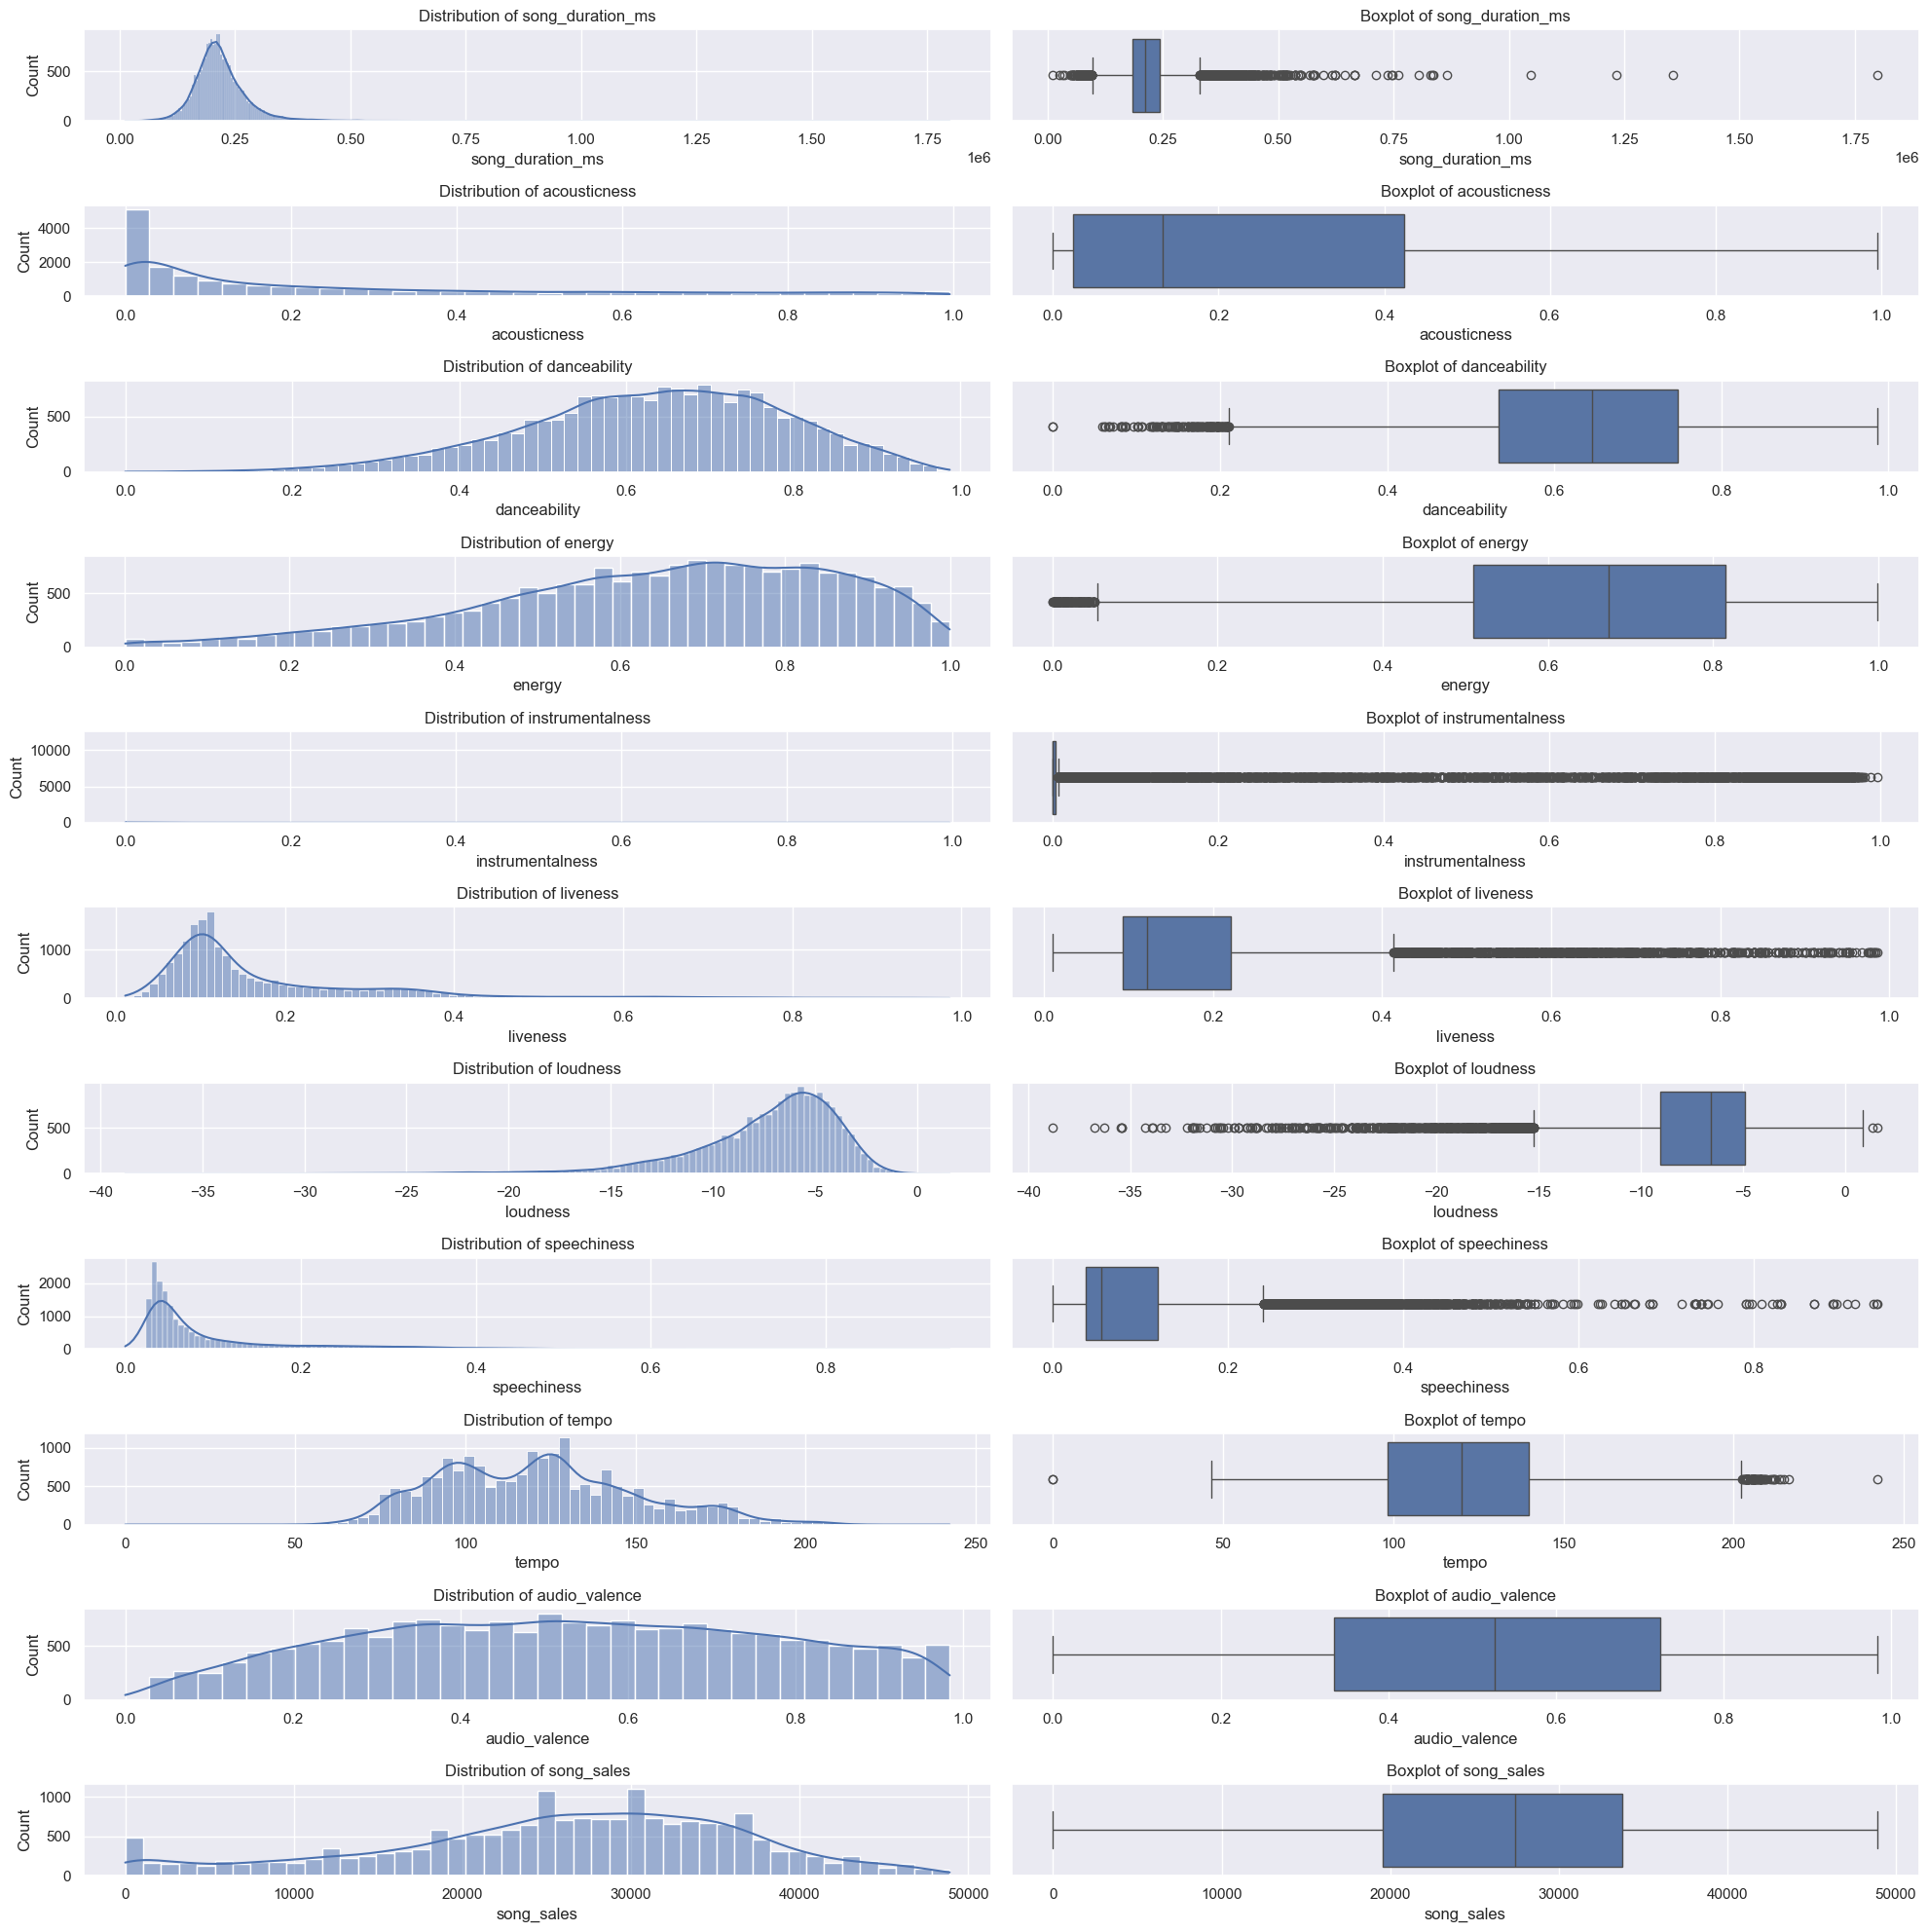

In [4]:
# Set the style of the plots
sns.set(style="darkgrid")
# Define a function to plot histograms and box plots for numeric features
def plot_numeric_distribution(data, features):
    fig, axes = plt.subplots(features.__len__(), 2, figsize=(20, 20))

    for i, feature in enumerate(features):
        sns.histplot(data[feature], kde=True, ax=axes[i][0])
        axes[i][0].set_title(f'Distribution of {feature}')

        sns.boxplot(x=data[feature], ax=axes[i][1])
        axes[i][1].set_title(f'Boxplot of {feature}')

    plt.tight_layout()
    plt.show()

# Plot the distribution of target variable and numeric features
plot_numeric_distribution(data, numerical_features)

3. Outlier Detection...

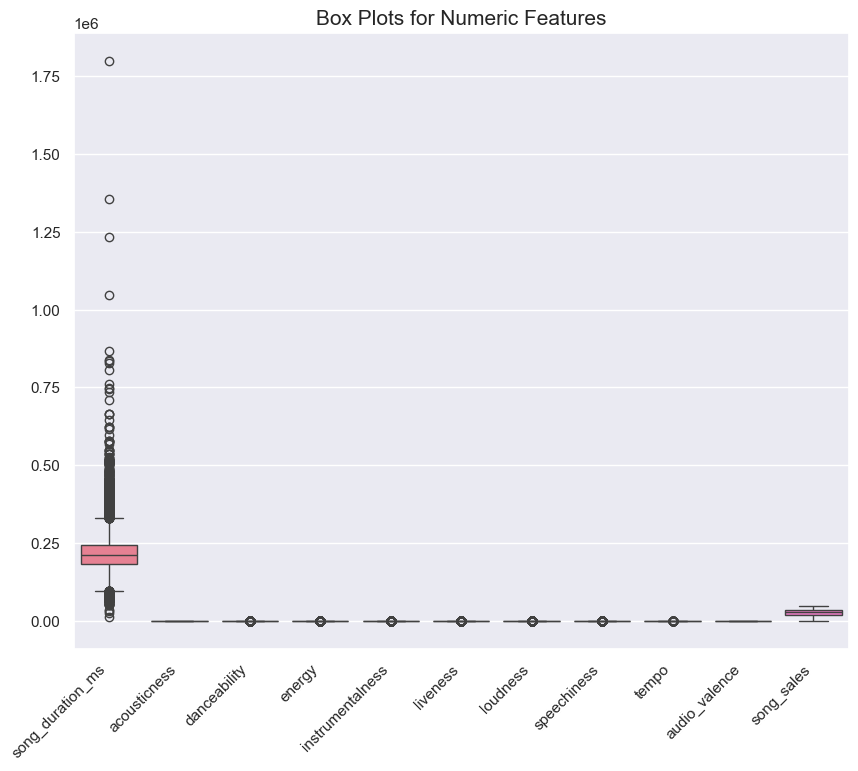

In [5]:
# Plot box plots for numeric features
plt.figure(figsize=(10, 8))
sns.boxplot(data=data[numerical_features])
plt.title('Box Plots for Numeric Features', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.show()

In [6]:
# Removing outliers using Z-Score
from scipy.stats import zscore

# Calculate Z-Score for each numeric feature
z_scores = zscore(data[numerical_features])

# Define a threshold for identifying outliers (|Z-Score| > 4)
outliers = (abs(z_scores) > 4).any(axis=1)

# Remove rows with outliers
cleaned_data = data[~outliers]
print(data.shape)
print(cleaned_data.shape)

(18835, 15)
(18319, 15)


4. Feature Relationships

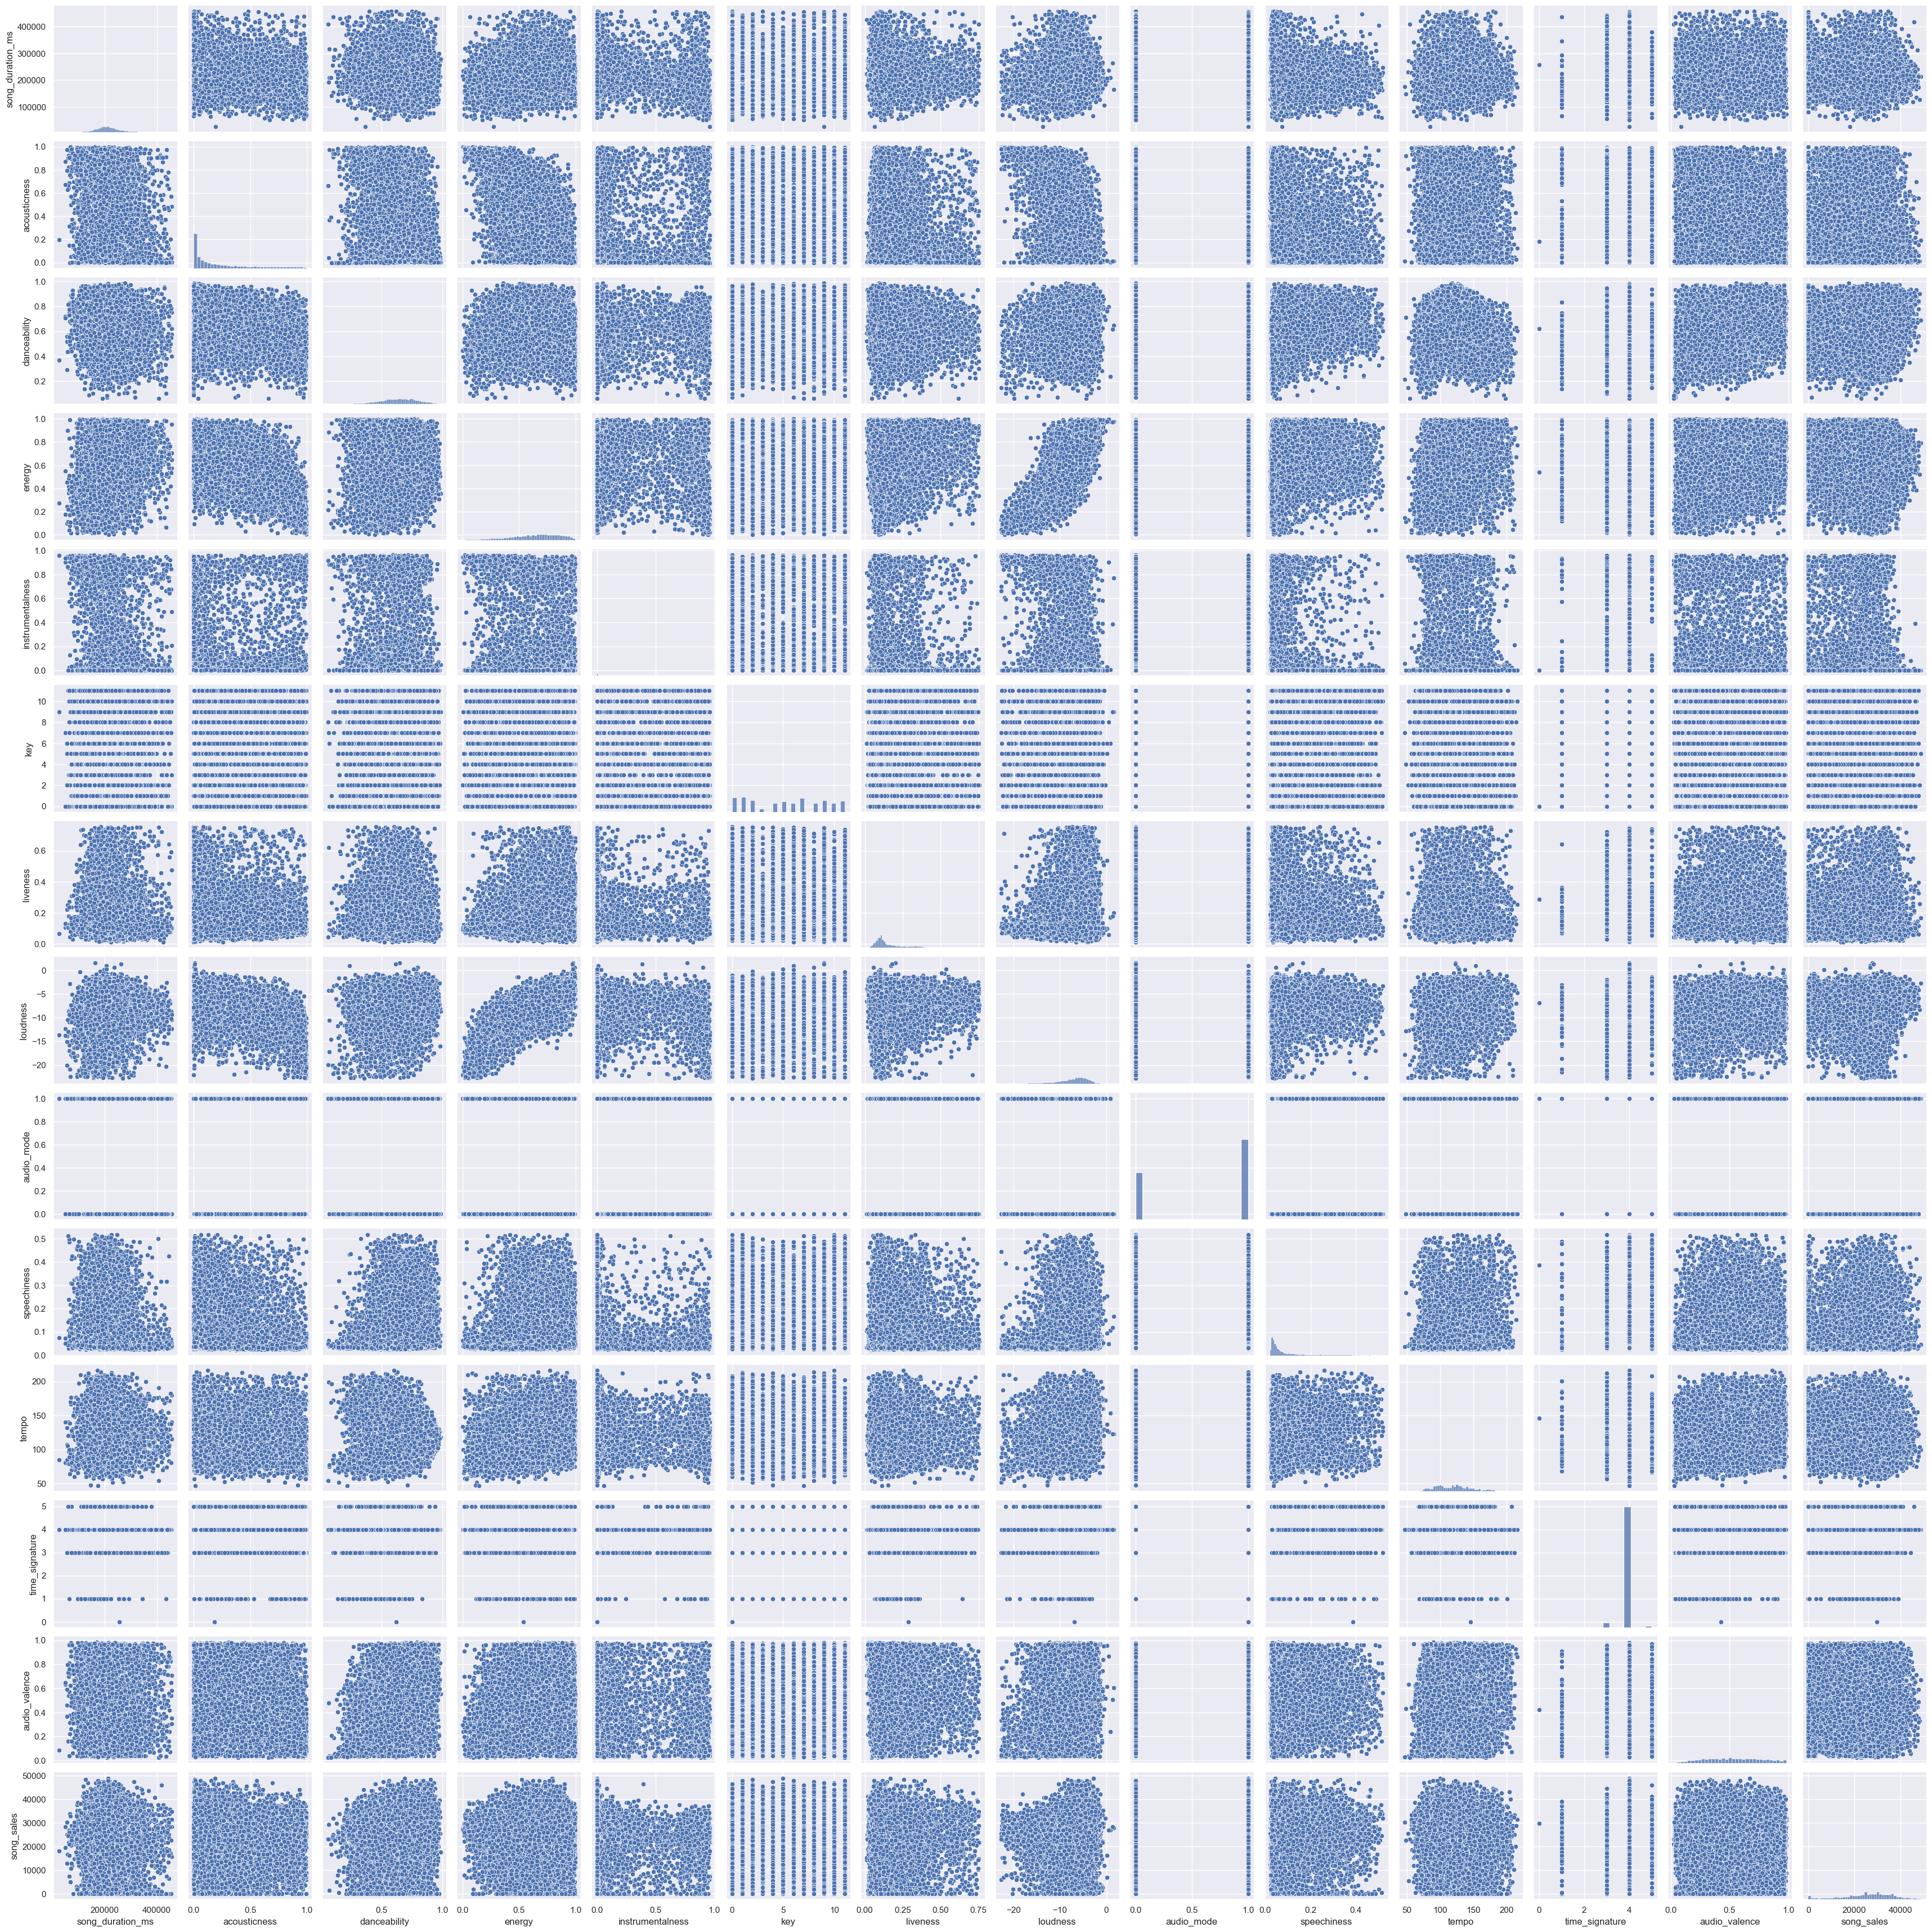

In [9]:
# Select relevant features for pair plot (excluding song_name)
features_for_pair_plot = ['song_duration_ms', 'acousticness', 'danceability', 'energy',
                           'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode',
                           'speechiness', 'tempo', 'time_signature', 'audio_valence', 'song_sales']
# Create a pair plot
sns.pairplot(cleaned_data[features_for_pair_plot])
plt.show()

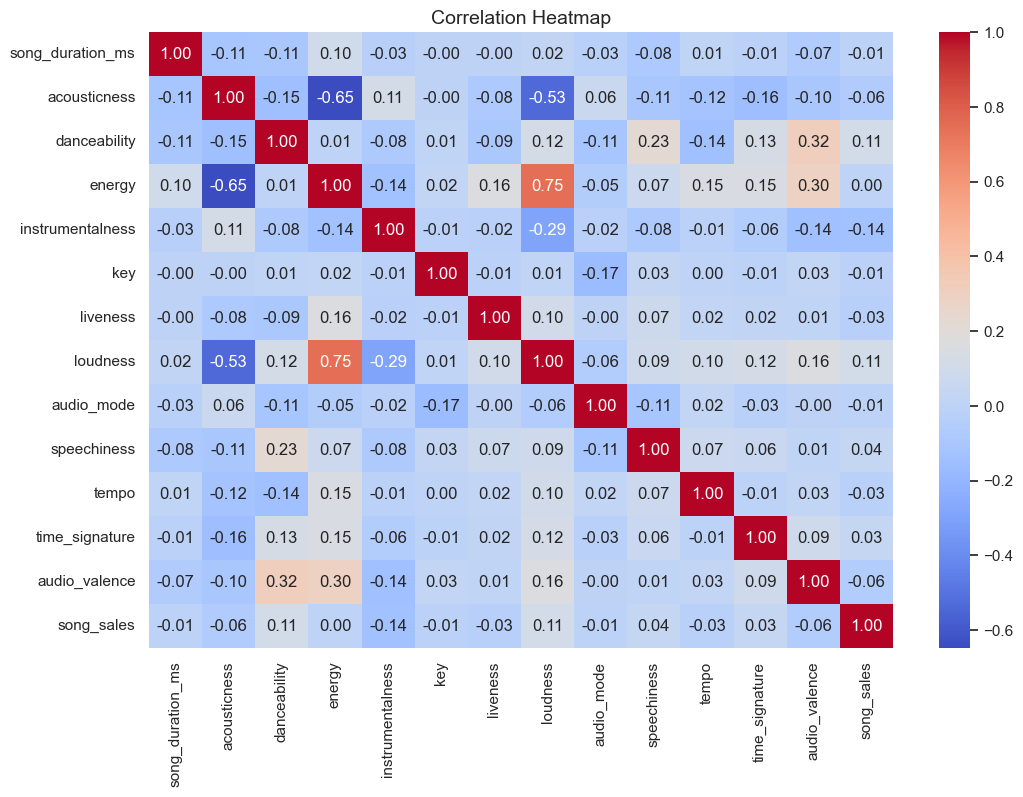

In [10]:
# Calculate correlation matrix
correlation_matrix = cleaned_data[features_for_pair_plot].corr()

# Display correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

In [11]:
df_cat = pd.DataFrame(cleaned_data[categorical_features])
print(df_cat)

       key  audio_mode  time_signature
0        8           1               4
1        3           0               4
2        0           1               4
3        0           1               4
4       10           1               4
...    ...         ...             ...
18830   11           1               4
18831   11           0               4
18832    0           1               4
18833    3           1               4
18834    4           1               4

[18319 rows x 3 columns]


In [12]:
from itertools import product

df_cat_new = df_cat.dropna()

## Creating all possible combinations between the above two variables list
cat_var_prod = list(product(df_cat_new,df_cat_new, repeat = 1))
cat_var_prod

[('key', 'key'),
 ('key', 'audio_mode'),
 ('key', 'time_signature'),
 ('audio_mode', 'key'),
 ('audio_mode', 'audio_mode'),
 ('audio_mode', 'time_signature'),
 ('time_signature', 'key'),
 ('time_signature', 'audio_mode'),
 ('time_signature', 'time_signature')]

In [13]:
import scipy.stats as ss
## Creating an empty variable and picking only the p value from the output of Chi-Square test
result = []
for i in cat_var_prod:
  if i[0] != i[1]:
    result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(df_cat_new[i[0]], df_cat_new[i[1]])))[1]))

result

[('key', 'audio_mode', np.float64(0.0)),
 ('key', 'time_signature', np.float64(0.0003210313809486872)),
 ('audio_mode', 'key', np.float64(0.0)),
 ('audio_mode', 'time_signature', np.float64(0.011298230792175205)),
 ('time_signature', 'key', np.float64(0.00032103138094868465)),
 ('time_signature', 'audio_mode', np.float64(0.011298230792175193))]

In [ ]:
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'coeff'])
## Using pivot function to convert the above DataFrame into a crosstab
chi_test_output.pivot(index='var1', columns='var2', values='coeff')

var2            audio_mode       key  time_signature
var1                                                
audio_mode             NaN  0.000000        0.011298
key               0.000000       NaN        0.000321
time_signature    0.011298  0.000321             NaN

In [ ]:
# Calculate the variance vector, matrix
variance_vector = cleaned_data[numerical_features].var()
covariance_matrix = cleaned_data[numerical_features].cov()

# Normalize the covariance values
normalized_covariance_matrix = covariance_matrix.copy()

for i in range(len(numerical_features)):
    for j in range(len(numerical_features)):
        normalized_covariance_matrix.iloc[i, j] /= np.sqrt(variance_vector[i] * variance_vector[j])

# Create a DataFrame with variances as rows and covariances as columns
variance_covariance_df = pd.concat([variance_vector, normalized_covariance_matrix.T], axis=1)
variance_covariance_df.columns = ['Variance'] + numerical_features
print(variance_covariance_df)

                      Variance  song_duration_ms  acousticness  danceability  \
song_duration_ms  2.694973e+09          1.000000     -0.112737     -0.106396   
acousticness      7.999329e-02         -0.112737      1.000000     -0.152501   
danceability      2.365809e-02         -0.106396     -0.152501      1.000000   
energy            4.321300e-02          0.097142     -0.648300      0.007050   
instrumentalness  4.300940e-02         -0.034578      0.111968     -0.079780   
liveness          1.630138e-02         -0.000997     -0.083690     -0.088405   
loudness          1.147700e+01          0.019898     -0.534330      0.117892   
speechiness       9.455632e-03         -0.081989     -0.106569      0.225218   
tempo             8.120911e+02          0.012408     -0.120953     -0.140134   
audio_valence     5.916980e-02         -0.068412     -0.097743      0.316302   
song_sales        1.153917e+08         -0.009040     -0.064408      0.107525   

                    energy  instrumenta

<ipython-input-52-59e3af35249e>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized_covariance_matrix.iloc[i, j] /= np.sqrt(variance_vector[i] * variance_vector[j])


5. Multicollinearity Analysis...

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

features_for_vif = ['song_duration_ms', 'acousticness', 'danceability', 'energy',
                    'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode',
                    'speechiness', 'tempo', 'time_signature', 'audio_valence']

# Create an empty DataFrame to store pairwise VIF values
pairwise_vif_data = pd.DataFrame(index=features_for_vif, columns=features_for_vif)

for i in range(len(features_for_vif)):
    for j in range(i, len(features_for_vif)):
        vif = variance_inflation_factor(data[features_for_vif].values, j)
        pairwise_vif_data.loc[features_for_vif[i], features_for_vif[j]] = vif
        pairwise_vif_data.loc[features_for_vif[j], features_for_vif[i]] = vif

print(pairwise_vif_data)

                 song_duration_ms acousticness danceability     energy  \
song_duration_ms        14.265089     3.177762     21.62545  30.732653   
acousticness             3.177762     3.177762     21.62545  30.732653   
danceability             21.62545     21.62545     21.62545  30.732653   
energy                  30.732653    30.732653    30.732653  30.732653   
instrumentalness         1.400073     1.400073     1.400073   1.400073   
key                      3.208983     3.208983     3.208983   3.208983   
liveness                 2.681362     2.681362     2.681362   2.681362   
loudness                11.940959    11.940959    11.940959  11.940959   
audio_mode                2.80587      2.80587      2.80587    2.80587   
speechiness              2.154095     2.154095     2.154095   2.154095   
tempo                   18.285176    18.285176    18.285176  18.285176   
time_signature          88.901818    88.901818    88.901818  88.901818   
audio_valence            7.716693     

6. Implement Linear Regression...

In [ ]:
numerical_data = copy.deepcopy(numerical_features)
numerical_data.remove('song_sales')

from sklearn.model_selection import train_test_split

X = cleaned_data.drop(columns=['song_sales'])  # Features (exclude the target variable)
y = cleaned_data['song_sales']  # Target variable

In [ ]:
X_numerical = X[numerical_data]

scaler = StandardScaler()
X_normalized_numerical = scaler.fit_transform(X_numerical)

# categorical_features = X.drop(columns=numerical_data)
X_normalized = np.concatenate((X_normalized_numerical, X[categorical_features]), axis=1)
# X_normalized = X_normalized_numerical
X_normalized[0]

array([ 0.87798453, -0.87371957, -0.91495495,  0.15787704, -0.33785511,
       -0.89444866,  0.93884455, -0.72363446,  1.60834291, -0.2359978 ,
        8.        ,  1.        ,  4.        ])

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
X_train

array([[-0.2255237 , -0.76205967,  0.18381992, ..., 11.        ,
         1.        ,  4.        ],
       [-0.46286899, -0.84585763, -0.0177305 , ...,  6.        ,
         0.        ,  4.        ],
       [ 0.02879272, -0.77019197,  0.61942889, ...,  6.        ,
         0.        ,  4.        ],
       ...,
       [ 0.72670846, -0.65386485, -0.97346958, ...,  8.        ,
         1.        ,  4.        ],
       [ 1.04621247, -0.77797068,  1.37361756, ...,  4.        ,
         0.        ,  4.        ],
       [ 0.51351957,  0.08617364,  0.58041913, ...,  6.        ,
         1.        ,  4.        ]])

In [ ]:
def gradient_descent(X, y, learning_rate, num_iterations):
    """
    Perform gradient descent to optimize the weights for a linear regression model.

    Args:
    X: A numpy array of shape (m, n), where m is the number of examples, and n is the number of features.
    y: A numpy array of shape (m, 1) representing the target values.
    learning_rate: The learning rate for gradient descent.
    num_iterations: The number of iterations to run gradient descent.

    Returns:
    w: A numpy array of shape (n + 1, 1) representing the learned weights (including bias).
    costs: A list of cost values at each iteration.
    """

    m, n = X.shape
    w = np.zeros((n + 1, 1))
    X = np.hstack((np.ones((m, 1)), X))
    y = y.reshape(-1, 1)
    costs = []

    for iteration in range(num_iterations):
        y_pred = np.dot(X, w)  # Predictions for all examples
        error = y_pred - y

        # Compute gradient
        gradient = np.dot(X.T, error) / m
        # Update weights
        w -= learning_rate * gradient
        # Compute cost
        cost = np.sum(error**2) / (2 * m)

    return w

In [ ]:
def predict(X_test, w):
    """
    Predict target values using learned weights.

    Args:
    X_test: A numpy array of shape (m, n), where m is the number of examples, and n is the number of features.
    w: A numpy array of shape (n + 1, 1) representing the learned weights (including bias).

    Returns:
    y_pred: A numpy array of shape (m, 1) representing the predicted target values.
    """

    m, n = X_test.shape
    # Add a column of ones for the bias term
    X_test = np.hstack((np.ones((m, 1)), X_test))
    y_pred = np.dot(X_test, w)

    return y_pred

In [ ]:
start_time = time.time()
w = gradient_descent(X_train, y_train.to_numpy(), learning_rate=0.03, num_iterations=100000)
end_time = time.time()
custom_train_time = end_time - start_time

y_pred_custom = predict(X_test, w)

In [ ]:
from sklearn.linear_model import LinearRegression

start_time = time.time()

sklearn_lr = LinearRegression()
sklearn_lr.fit(X_train, y_train)

end_time = time.time()
sklearn_train_time = end_time - start_time

y_pred_sklearn = sklearn_lr.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import time

# Evaluate the performance
mse_custom = mean_squared_error(y_test, y_pred_custom)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)

r2_custom = r2_score(y_test, y_pred_custom)
r2_sklearn = r2_score(y_test, y_pred_sklearn)

print(f"Mean Squared Error (Custom): {mse_custom}")
print(f"Mean Squared Error (Scikit-learn): {mse_sklearn}")
print("")
print(f"R2 Score (Custom): {r2_custom}")
print(f"R2 Score (Scikit-learn): {r2_sklearn}")

# Measure runtime for custom model
start_time = time.time()
y_pred_custom = predict(X_test, w)
custom_runtime = time.time() - start_time

# Measure runtime for scikit-learn model
start_time = time.time()
y_pred_sklearn = sklearn_lr.predict(X_test)
sklearn_runtime = time.time() - start_time

print("")
print(f"Prediction Time (Custom): {custom_runtime} seconds")
print(f"Prediction Time (Scikit-learn): {sklearn_runtime} seconds")
print("")
print(f"Training Time (Custom): {custom_train_time} seconds")
print(f"Training Time (Scikit-learn): {sklearn_train_time} seconds")

Mean Squared Error (Custom): 108014624.59630416
Mean Squared Error (Scikit-learn): 108014625.38866526

R2 Score (Custom): 0.04714830278283311
R2 Score (Scikit-learn): 0.047148295793014605

Prediction Time (Custom): 0.008478403091430664 seconds
Prediction Time (Scikit-learn): 0.003144979476928711 seconds

Training Time (Custom): 57.13363814353943 seconds
Training Time (Scikit-learn): 0.08011031150817871 seconds


7. Lasso vs. Ridge Regression...

In [ ]:
def ridge_gradient_descent(X, y, learning_rate, num_iterations, ridge_lambda):
    m, n = X.shape
    w = np.zeros((n + 1, 1))
    X = np.hstack((np.ones((m, 1)), X))
    y = y.reshape(-1, 1)
    costs = []

    for iteration in range(num_iterations):
        y_pred = np.dot(X, w)
        error = y_pred - y
        gradient = np.dot(X.T, error) / m

        # Add the L2 regularization term to the gradient
        ridge_term = ridge_lambda * w
        ridge_term[0] = 0  # Exclude the bias term from regularization
        gradient += ridge_term

        w -= learning_rate * gradient

        cost = (np.sum(error**2) + ridge_lambda * np.sum(w**2)) / (2 * m)
        costs.append(cost)

        if iteration % 10000 == 0:
            print(f"Iteration {iteration}: Cost = {cost}")

    return w

In [ ]:
start_time = time.time()
ridge_w = ridge_gradient_descent(X_train, y_train.to_numpy(), learning_rate=0.02, num_iterations=100000, ridge_lambda=0.1)
end_time = time.time()
ridge_train_time = end_time - start_time

y_pred_ridge = predict(X_test, ridge_w)

Iteration 0: Cost = 395961128.5761969
Iteration 10000: Cost = 54864457.70510592
Iteration 20000: Cost = 54853746.28929878
Iteration 30000: Cost = 54854990.72314201
Iteration 40000: Cost = 54855191.9549537
Iteration 50000: Cost = 54855218.31644406
Iteration 60000: Cost = 54855221.69049705
Iteration 70000: Cost = 54855222.121091075
Iteration 80000: Cost = 54855222.17602277
Iteration 90000: Cost = 54855222.183030166


In [ ]:
def lasso_gradient_descent(X, y, learning_rate, num_iterations, lasso_lambda):
    m, n = X.shape
    w = np.zeros((n + 1, 1))
    X = np.hstack((np.ones((m, 1)), X))
    y = y.reshape(-1, 1)
    costs = []

    for iteration in range(num_iterations):
        y_pred = np.dot(X, w)
        error = y_pred - y
        gradient = np.dot(X.T, error) / m

        # Add the L1 regularization term to the gradient
        lasso_term = lasso_lambda * np.sign(w)
        gradient[1:] += lasso_term[1:]  # Exclude the bias term from regularization

        w -= learning_rate * gradient

        cost = (np.sum(error**2) + lasso_lambda * np.sum(np.abs(w))) / (2 * m)
        costs.append(cost)

        if iteration % 10000 == 0:
            print(f"Iteration {iteration}: Cost = {cost}")

    return w

In [ ]:
start_time = time.time()
lasso_w = lasso_gradient_descent(X_train, y_train.to_numpy(), learning_rate=0.01, num_iterations=100000, lasso_lambda=0.1)
end_time = time.time()
lasso_training_time = end_time - start_time

y_pred_lasso = predict(X_test, lasso_w)

Iteration 0: Cost = 395961087.04829526
Iteration 10000: Cost = 55310866.15591188
Iteration 20000: Cost = 54997462.66534935
Iteration 30000: Cost = 54874782.9805795
Iteration 40000: Cost = 54826768.51263828
Iteration 50000: Cost = 54807981.37330126
Iteration 60000: Cost = 54800633.3309309
Iteration 70000: Cost = 54797761.23948545
Iteration 80000: Cost = 54796639.818400055
Iteration 90000: Cost = 54796202.693185136


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import time

# Evaluate the performance
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Mean Squared Error (Ridge): {mse_ridge}")
print(f"Mean Squared Error (Lasso): {mse_lasso}")

print("")
print(f"R2 Score (Ridge): {r2_custom}")
print(f"R2 Score (Lasso): {r2_sklearn}")

print("")
print(f"Training Time (Ridge): {ridge_train_time} seconds")
print(f"Training Time (Lasso): {lasso_training_time} seconds")

Mean Squared Error (Ridge): 108091956.86037835
Mean Squared Error (Lasso): 108005648.02424583

R2 Score (Ridge): 0.04714830278283311
R2 Score (Lasso): 0.047148295793014605

Training Time (Ridge): 50.228381395339966 seconds
Training Time (Lasso): 43.357879638671875 seconds


10. Model Evaluation...

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_custom = mean_absolute_error(y_test, y_pred_custom)
rmse_custom = np.sqrt(mse_custom)

print(f"Mean Squared Error: {mse_custom}")
print(f"R2 Score: {r2_custom}")
print(f"Mean Absolute Error: {mae_custom}")
print(f"Root Mean Squared Error: {rmse_custom}")

Mean Squared Error: 108014624.59630416
R2 Score: 0.04714830278283311
Mean Absolute Error: 8221.2120048122
Root Mean Squared Error: 10393.008447812605
